In [1]:
import os
import sys

sys.path.extend([
    "C:\\Users\\Wyss User\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages",
    "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\src",
])

from brainrnaseq_specificity import map_hgnc_ids, create_enrichment_dataframe, calculate_enrichment
from deeptmhmm_localization import identify_localization, parse_gz_file
from identify_targets import identify_targets
from olink_fractionation import analyze_fractionation
from raw_data_preprocessing import clean_up_raw_data, plot_protein_fractionation, ev_association_score_df, find_ratio

from io import StringIO

import pandas as pd
import requests

os.chdir("C:\\Users\\Wyss User\\Documents\\EVs\\OLINK")

In [2]:
assay_list_path = "data\\231220_ht_panel_assay_list.xlsx"
brain_rna_seq_raw_path = "data\\240411_brain_rna_seq_raw.csv"
output_directory = "outputs\\ht_output"
plate_layout_path = "data\\231204_Walt_Olink_HT_Plate.xlsx"
raw_data = "data\\240214_Walt_Olink_HT_Raw.parquet"
uniprot_fasta_database = "data\\uniprot_fasta_database.gz"

In [3]:
# Create a tidy dataframe from the raw data file.
tidy_data = clean_up_raw_data(raw_data, plate_layout_path)

C:\Users\Wyss User\Documents\EVs\OLINK\src\raw_data_preprocessing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_data.loc[:, "Linear NPX"] = unique_data["PCNormalizedNPX"].map(lambda x: 2**x)


In [4]:
# SI tables 6, 7, and 8

# Find proteins with a tau score of less than 0.25
hgnc_ids = (
    "https://storage.googleapis.com/public-download-files/hgnc/tsv/tsv/hgnc_complete_set.txt"
)
brain_rna_seq = pd.read_csv(brain_rna_seq_raw_path)

hgnc_uniprot_mapping_data = pd.read_csv(
    (StringIO(requests.get(hgnc_ids).text)),
    sep="\t",
    usecols=["hgnc_id", "uniprot_ids", "symbol", "name", "alias_symbol", "alias_name"],
)

hgnc_uniprot_mapping_data["uniprot_ids"] = hgnc_uniprot_mapping_data[
    "uniprot_ids"
].str.split("|")
hgnc_uniprot_mapping_data = hgnc_uniprot_mapping_data.explode("uniprot_ids")
hgnc_uniprot_mapping_data = hgnc_uniprot_mapping_data.reset_index(drop=True)

brain_rna_seq = pd.merge(
    brain_rna_seq,
    hgnc_uniprot_mapping_data,
    left_on="id",
    right_on="hgnc_id",
    how="inner",
)
brain_rna_seq.dropna(subset=["uniprot_ids"], inplace=True)
brain_rna_seq.drop_duplicates(subset=["uniprot_ids"], inplace=True)
brain_rna_seq.set_index(["uniprot_ids", "symbol", "name", "alias_symbol", "alias_name"], inplace = True)

expression_df = create_enrichment_dataframe(brain_rna_seq)

enrichment_values = expression_df.apply(
            lambda row: calculate_enrichment(row, "tau"), axis=1
        )

low_tau_score = enrichment_values[enrichment_values < 0.25]

# Find proteins with the correct fractionation pattern
fractionation_uniprot_ids = analyze_fractionation(
    tidy_data,
    ["9", "10"],
    ["7", "11", "12", "13"],
    sample_health="healthy",
    mean_median_individual="individual_median",
)

#Find external, internal, and transmembrane proteins
fasta_sequences = parse_gz_file(uniprot_fasta_database)
fasta_sequences.update(
    {
        "NTproBNP": "HPLGSPGSASDLETSGLQEQRNHLQGKLSELQVEQTSLEPLQESPRPTGVWKSREVATEGIRGHRKMVLYTLRAPR",
        "O43521-2": "MAKQPSDVSSECDREGRQLQPAERPPQLRPGAPTSLQTEPQDRSPAPMSCDKSTQTPSPPCQAFNHYLSAMASMRQAEPADMRPEIWIAQELRRIGDEFNAYYARRVFLNNYQAAEDHPRMVILRLLRYIVRLVWRMH",
        "Q13114-2": "MESSKKMDSPGALQTNPPLKLHTDRSAGTPVFVPEQGGYKEKFVKTVEDKYKCEKCHLVLCSPKQTECGHRFCESCMAALLSSSSPKCTACQESIVKDKVFKDNCCKREILALQIYCRNESRGCAEQLMLGHLLVHLKNDCHFEELPCVRPDCKEKVLRKDLRDHVEKACKYREATCSHCKSQVPMIALQVSLLQNESVEKNKSIQSLHNQICSFEIEIERQKEMLRNNESKILHLQRVIDSQAEKLKELDKEIRPFRQNWEEADSMKSSVESLQNRVTELESVDKSAGQVARNTGLLESQLSRHDQMLSVHDIRLADMDLRFQVLETASYNGVLIWKIRDYKRRKQEAVMGKTLSLYSQPFYTGYFGYKMCARVYLNGDGMGKGTHLSLFFVIMRGEYDALLPWPFKQKVTLMLMDQGSSRRHLGDAFKPDPNSSSFKKPTGEMNIASGCPVFVAQTVLENGTYIKDDTIFIKVIVDTSDLPDP",
        "O75882-2": "MVAAAAATEARLRRRTAATAALAGRSGGPHWDWDVTRAGRPGLGAGLRLPRLLSPPLRPRLLLLLLLLSPPLLLLLLPCEAEAAAAAAAVSGSAAAEAKECDRPCVNGGRCNPGTGQCVCPAGWVGEQCQHCGGRFRLTGSSGFVTDGPGNYKYKTKCTWLIEGQPNRIMRLRFNHFATECSWDHLYVYDGDSIYAPLVAAFSGLIVPERDGNETVPEVVATSGYALLHFFSDAAYNLTGFNITYSFDMCPNNCSGRGECKISNSSDTVECECSENWKGEACDIPHCTDNCGFPHRGICNSSDVRGCSCFSDWQGPGCSVPVPANQSFWTREEYSNLKLPRASHKAVVNGNIMWVVGGYMFNHSDYNMVLAYDLASREWLPLNRSVNNVVVRYGHSLALYKDKIYMYGGKIDSTGNVTNELRVFHIHNESWVLLTPKAKEQYAVVGHSAHIVTLKNGRVVMLVIFGHCPLYGYISNVQEYDLDKNTWSILHTQGALVQGGYGHSSVYDHRTRALYVHGGYKAFSANKYRLADDLYRYDVDTQMWTILKDSRFFRYLHTAVIVSGTMLVFGGNTHNDTSMSHGAKCFSSDFMAYDIACDRWSVLPRPDLHHDVNRFGHSAVLHNSTMYVFGGFNSLLLSDILVFTSEQCDAHRSEAACLAAGPGIRCVWNTGSSQCISWALATDEQEEKLKSECFSKRTLDHDRCDQHTDCYSCTANTNDCHWCNDHCVPRNHSCSEGQISIFRYENCPKDNPMYYCNKKTSCRSCALDQNCQWEPRNQECIALPENICGIGWHLVGNSCLKITTAKENYDNAKLFCRNHNALLASLTTQKKVEFVLKQLRIMQSSQSMSKLTLTPWVGLRKINVSYWCWEDMSPFTNSLLQWMPSEPSDAGFCGILSEPSTRGLKAATCINPLNGSVCERPANHSAKQCRTPCALRTACGDCTSGSSECMWCSNMKQCVDSNAYVASFPFGQCMEWYTMSTCPPENCSGYCTCSHCLEQPGCGWCTDPSNTGKGKCIEGSYKGPVKMPSQAPTGNFYPQPLLNSSMCLEDSRYNWSFIHCPACQCNGHSKCINQSICEKCENLTTGKHCETCISGFYGDPTNGGKCQPCKCNGHASLCNTNTGKCFCTTKGVKGDECQLCEVENRYQGNPLRGTCYYTLLIDYQFTFSLSQEDDRYYTAINFVATPDEQNRDLDMFINASKNFNLNITWAASFSAGTQAGEEMPVVSKTNIKEYKDSFSNEKFDFRNHPNITFFVYVSNFTWPIKIQVQTE",
        "Q8WXW3-4": "MSRKISKESKKVNISSSLESEDISLETTVPTDDISSSEEREGKVRITRQLIERKELLHNIQLLKIELSQKTMMIDNLKVDYLTKIEELEEKLNDALHQKQLLTLRLDNQLAFQQKDASKYQELMKQEMETILLRQKQLEETNLQLREKAGDVRRNLRDFELTEEQYIKLKAFPEDQLSIPEYVSVRFYELVNPLRKEICELQVKKNILAEELSTNKNQLKQLTEELAAMKQILVKMHSKHSENSLLLTKTEPKHVTENQKSKTLNVPKEHEDNIFTPKPTLFTKKEAPEWSKKQKMKT",
    }
)
assays = pd.read_excel(assay_list_path)
assays["Sequence"] = assays["UniProt ID"].map(
    lambda x: fasta_sequences.get(x, "N/A")
)
tm_uniprot_ids = identify_localization(assays, "TMhelix", output_directory)
int_uniprot_ids = identify_localization(assays, "internal", output_directory)
ext_uniprot_ids = identify_localization(assays, "external", output_directory)

# List of proteins that are internal with the correct fractionation pattern and a low tau score
int_low_tau = low_tau_score[
    (low_tau_score.index.get_level_values("uniprot_ids").isin(int_uniprot_ids))
    & (low_tau_score.index.get_level_values("uniprot_ids").isin(fractionation_uniprot_ids))
    ]

# List of proteins that are transmembrane with the correct fractionation pattern and a low tau score
tm_low_tau = low_tau_score[
    (low_tau_score.index.get_level_values("uniprot_ids").isin(tm_uniprot_ids))
    & (low_tau_score.index.get_level_values("uniprot_ids").isin(fractionation_uniprot_ids))
    ]

# List of proteins that are external with the correct fractionation pattern and a low tau score
ext_low_tau = low_tau_score[
    (low_tau_score.index.get_level_values("uniprot_ids").isin(ext_uniprot_ids))
    & (low_tau_score.index.get_level_values("uniprot_ids").isin(fractionation_uniprot_ids))
    ]

# Add fractionation scores to the dataframe of internal proteins with low tau scores
int_low_tau_fractionation_scores = []
for protein in list(int_low_tau.index.get_level_values("uniprot_ids")):
    df = tidy_data[protein]
    ratio = find_ratio(df, ["9", "10"], ["7", "11" "12", "13"])
    int_low_tau_fractionation_scores.append(ratio)

int_low_tau = int_low_tau.reset_index()
int_low_tau["ev_association_score"] = int_low_tau_fractionation_scores
int_low_tau["localization"] = "internal"

# Add fractionation scores to the dataframe of transmembrane proteins with low tau scores
tm_low_tau_fractionation_scores = []
for protein in list(tm_low_tau.index.get_level_values("uniprot_ids")):
    df = tidy_data[protein]
    ratio = find_ratio(df, ["9", "10"], ["7", "11" "12", "13"])
    tm_low_tau_fractionation_scores.append(ratio)

tm_low_tau = tm_low_tau.reset_index()
tm_low_tau["ev_association_score"] = tm_low_tau_fractionation_scores
tm_low_tau["localization"] = "transmembrane"

# Add fractionation scores to the dataframe of external proteins with low tau scores
ext_low_tau_fractionation_scores = []
for protein in list(ext_low_tau.index.get_level_values("uniprot_ids")):
    df = tidy_data[protein]
    ratio = find_ratio(df, ["9", "10"], ["7", "11" "12", "13"])
    ext_low_tau_fractionation_scores.append(ratio)

ext_low_tau = ext_low_tau.reset_index()
ext_low_tau["ev_association_score"] =ext_low_tau_fractionation_scores
ext_low_tau['localization'] = "external"

# Concatenate the dataframes
low_tau_with_fract_pattern = pd.concat([int_low_tau, tm_low_tau])
low_tau_with_fract_pattern = pd.concat([low_tau_with_fract_pattern, ext_low_tau])

In [5]:
# SI tables 3, 4, and 5

# Internal
int_with_fract_pattern = set(int_uniprot_ids) & set(fractionation_uniprot_ids)

int_fractionation_scores = []
int_proteins = []

for protein in int_with_fract_pattern:
    df = tidy_data[protein]
    ratio = find_ratio(df, ["9", "10"], ["7", "11" "12", "13"])
    int_fractionation_scores.append(ratio)
    int_proteins.append(protein)

int_with_fract_df = pd.DataFrame({"uniprot_ids": int_proteins, "ev_association_score": int_fractionation_scores})
int_with_fract_df = int_with_fract_df.merge(hgnc_uniprot_mapping_data, on="uniprot_ids")
int_with_fract_df['localization'] = 'internal'

# Transmembrane
tm_with_fract_pattern = set(tm_uniprot_ids) & set(fractionation_uniprot_ids)

tm_fractionation_scores = []
tm_proteins = []

for protein in tm_with_fract_pattern:
    df = tidy_data[protein]
    ratio = find_ratio(df, ["9", "10"], ["7", "11" "12", "13"])
    tm_fractionation_scores.append(ratio)
    tm_proteins.append(protein)

tm_with_fract_df = pd.DataFrame({"uniprot_ids": tm_proteins, "ev_association_score": tm_fractionation_scores})
tm_with_fract_df = tm_with_fract_df.merge(hgnc_uniprot_mapping_data, on="uniprot_ids")
tm_with_fract_df['localization'] = 'internal'

# External
ext_with_fract_pattern = set(ext_uniprot_ids) & set(fractionation_uniprot_ids)

ext_fractionation_scores = []
ext_proteins = []

for protein in ext_with_fract_pattern:
    df = tidy_data[protein]
    ratio = find_ratio(df, ["9", "10"], ["7", "11" "12", "13"])
    ext_fractionation_scores.append(ratio)
    ext_proteins.append(protein)

ext_with_fract_df = pd.DataFrame({"uniprot_ids": ext_proteins, "ev_association_score": ext_fractionation_scores})
ext_with_fract_df = ext_with_fract_df.merge(hgnc_uniprot_mapping_data, on="uniprot_ids")
ext_with_fract_df['localization'] = 'external'

# Concatenate the dataframes
fract_pattern = pd.concat([int_with_fract_df, tm_with_fract_df])
fract_pattern = pd.concat([fract_pattern, ext_with_fract_df])

In [6]:
# generate the data for figure 1d and 1e

associated_proteins = []
associated_samples = []
associated_median_npx = []

fig_1d_associated = ["P08758", "P07355", "P09525", "Q9NP79"]
fig_1d_contaminant = ["P02751", "P00734", "P36955", "P01024"]

tidy_data_sec = tidy_data[
    (tidy_data.index.get_level_values("Health") == "Healthy")
    & (tidy_data.index.get_level_values("Sample").str.contains("SEC"))
]

for column in fig_1d_associated:
    df = tidy_data_sec[column]

    for sample in list(df.index.get_level_values("Sample").unique()):
        associated_proteins.append(column)
        associated_samples.append(sample)
        sample_df = df[df.index.get_level_values("Sample") == sample]
        associated_median_npx.append(sample_df.median())

associated_proteins_df = pd.DataFrame({"protein": associated_proteins, "sample": associated_samples, "median_npx": associated_median_npx})

contaminant_proteins = []
contaminant_samples = []
contaminant_median_npx = []

for column in fig_1d_contaminant:
    df = tidy_data_sec[column]

    for sample in list(df.index.get_level_values("Sample").unique()):
        contaminant_proteins.append(column)
        contaminant_samples.append(sample)
        sample_df = df[df.index.get_level_values("Sample") == sample]
        contaminant_median_npx.append(sample_df.median())

contaminant_proteins_df = pd.DataFrame({"protein": contaminant_proteins, "sample": contaminant_samples, "median_npx": contaminant_median_npx})

associated_proteins = associated_proteins_df.pivot(columns = "protein", index = "sample")
associated_proteins.to_excel("associated_proteins.xlsx")

contaminant_proteins = contaminant_proteins_df.pivot(columns = "protein", index = "sample")
contaminant_proteins.to_excel("contaminant_proteins.xlsx")

In [7]:
# identify targets found inside microglia cells that may be EV associated using the raw data file

identify_targets(
    assay_list_path = assay_list_path,
    uniprot_fasta_database = uniprot_fasta_database, 
    brain_rna_seq_raw_path = brain_rna_seq_raw_path,
    region = "internal", 
    cell_type = "microglia", 
    specificity_metric = "tau", 
    specificity_cutoff = 0.75,
    high_fractions = ['9', '10'], 
    low_fractions = ['7', '11', '12', '13'], 
    sample_health = 'healthy', 
    mean_median_individual = 'individual_median',
    raw_olink_data_file = raw_data,
    plate_layout_dataframe = plate_layout_path,
    output_directory = output_directory
    )

C:\Users\Wyss User\Documents\EVs\OLINK\src\raw_data_preprocessing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_data.loc[:, "Linear NPX"] = unique_data["PCNormalizedNPX"].map(lambda x: 2**x)


{'A2A288',
 'P14317',
 'P19838',
 'P57796',
 'Q12802',
 'Q6P0N0',
 'Q6P589',
 'Q7Z6K4',
 'Q9NP95',
 'Q9Y572'}

In [8]:
# identify targets found inside microglia cells that may be EV associated using the tidy dataframe

identify_targets(
    assay_list_path = assay_list_path,
    uniprot_fasta_database = uniprot_fasta_database, 
    brain_rna_seq_raw_path = brain_rna_seq_raw_path,
    region = "internal", 
    cell_type = "microglia", 
    specificity_metric = "tau", 
    specificity_cutoff = 0.75,
    high_fractions = ['9', '10'], 
    low_fractions = ['7', '11', '12', '13'], 
    sample_health = 'healthy', 
    mean_median_individual = 'individual_median',
    plate_layout_dataframe = plate_layout_path,
    tidy_dataframe = tidy_data,
    output_directory = output_directory
    )

{'A2A288',
 'P14317',
 'P19838',
 'P57796',
 'Q12802',
 'Q6P0N0',
 'Q6P589',
 'Q7Z6K4',
 'Q9NP95',
 'Q9Y572'}

<Axes: title={'center': 'Healthy Q9Y251 Fractionation Pattern, HT Panel'}, xlabel='Sample Description', ylabel='Delta'>

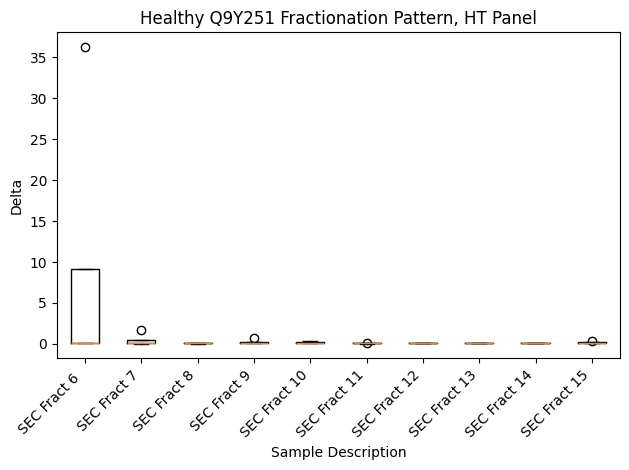

In [9]:
# make a box-and-whisker plot for a target of interest

plot_protein_fractionation(tidy_data, "Q9Y251")

In [10]:
import requests
import json
import time

def uniprot_id_mapping(from_db, to_db, ids):
    url = "https://rest.uniprot.org/idmapping/run"
    data = {
        "from": from_db,
        "to": to_db,
        "ids": " ".join(ids)
    }
    response = requests.post(url, data=data)
    response.raise_for_status()
    job_id = response.json()["jobId"]
    
    status_url = f"https://rest.uniprot.org/idmapping/status/{job_id}"
    results_url = f"https://rest.uniprot.org/idmapping/results/{job_id}"
    
    max_attempts = 5
    attempts = 0
    while attempts < max_attempts:
        try:
            status_response = requests.get(status_url)
            status_response.raise_for_status()
            status_data = status_response.json()
            
            if "jobStatus" in status_data:
                if status_data["jobStatus"] == "RUNNING":
                    time.sleep(5)
                elif status_data["jobStatus"] == "FINISHED":
                    break
                else:
                    print(f"Unexpected status: {status_data['jobStatus']}")
                    return None
            elif "results" in status_data:
                return process_results(status_data)
            else:
                print("Unexpected response format")
                return None
        except requests.exceptions.RequestException as e:
            print(f"Error checking job status: {e}")
            attempts += 1
            time.sleep(5)
    
    if attempts == max_attempts:
        print("Max attempts reached. Could not get job status.")
        return None
    
    try:
        results_response = requests.get(results_url)
        results_response.raise_for_status()
        return process_results(results_response.json())
    except requests.exceptions.RequestException as e:
        print(f"Error getting results: {e}")
        return None

def process_results(data):
    accession_to_id = {}
    if "results" in data:
        for result in data["results"]:
            to_data = result.get("to", {})
            uniprot_kb_id = to_data.get("uniProtkbId")
            if uniprot_kb_id:
                primary_accession = to_data.get("primaryAccession")
                if primary_accession:
                    accession_to_id[primary_accession] = uniprot_kb_id
                secondary_accessions = to_data.get("secondaryAccessions", [])
                for sec_acc in secondary_accessions:
                    accession_to_id[sec_acc] = uniprot_kb_id
    return accession_to_id

# # Example usage
# from_db = "UniProtKB_AC-ID"
# to_db = "UniProtKB"
# ids = list(transmembrane_endothelial)

# mapped_ids = uniprot_id_mapping(from_db, to_db, ids)
# if mapped_ids:
#     print("Accession to UniProtKB ID mapping:")
#     for accession, uniprot_kb_id in mapped_ids.items():
#         print(f"{accession}: {uniprot_kb_id}")
# else:
#     print("Mapping failed or returned no results.")
#     print("Try using the web interface: https://www.uniprot.org/id-mapping")
#     print("If the web interface works, the API might be having issues.")

# result_dict = mapped_ids if mapped_ids else {}

In [29]:
# Create a dataframe of tau and ev asssociation scores for external, internal, and transmembrane cell-type specific targets that meet fractionation and cell-type specificity criteria
def cell_type_ev_association_tau_scores(
    tidy_dataframe,
    assay_list_path,
    uniprot_fasta_database,
    brain_rna_seq_raw_path,
    cell_type,
    specificity_metric,
    specificity_cutoff,
    high_fractions,
    low_fractions,
    sample_health,
    mean_median_individual="individual_median",
    output_directory="ht_output",
):
    internal = identify_targets(
        tidy_dataframe = tidy_dataframe,
        assay_list_path = assay_list_path,
        uniprot_fasta_database = uniprot_fasta_database, 
        brain_rna_seq_raw_path = brain_rna_seq_raw_path,
        region = "internal", 
        cell_type = cell_type, 
        specificity_metric = specificity_metric, 
        specificity_cutoff = specificity_cutoff,
        high_fractions = high_fractions, 
        low_fractions = low_fractions, 
        sample_health = sample_health, 
        mean_median_individual = mean_median_individual,
        output_directory = output_directory,
        )
    external = identify_targets(
        tidy_dataframe = tidy_dataframe,
        assay_list_path = assay_list_path,
        uniprot_fasta_database = uniprot_fasta_database, 
        brain_rna_seq_raw_path = brain_rna_seq_raw_path,
        region = "external", 
        cell_type = cell_type, 
        specificity_metric = specificity_metric, 
        specificity_cutoff = specificity_cutoff,
        high_fractions = high_fractions, 
        low_fractions = low_fractions, 
        sample_health = sample_health, 
        mean_median_individual = mean_median_individual,
        output_directory = output_directory,
        )
    transmembrane = identify_targets(
        assay_list_path = assay_list_path,
        uniprot_fasta_database = uniprot_fasta_database, 
        brain_rna_seq_raw_path = brain_rna_seq_raw_path,
        region = "TMhelix", 
        cell_type = cell_type, 
        specificity_metric = specificity_metric, 
        specificity_cutoff = specificity_cutoff,
        high_fractions = high_fractions, 
        low_fractions = low_fractions, 
        sample_health = sample_health, 
        mean_median_individual = mean_median_individual,
        tidy_dataframe = tidy_dataframe,
        output_directory = output_directory
        )
    
    # Create dataframe of BrainRNA-Seq data
    hgnc_ids = ("https://storage.googleapis.com/public-download-files/hgnc/tsv/tsv/hgnc_complete_set.txt")
    hgnc_uniprot_mapping_data = pd.read_csv(
        (StringIO(requests.get(hgnc_ids).text)),
        sep="\t",
        usecols=["symbol", "uniprot_ids", "name", "alias_symbol", "alias_name"],
    )
    brain_rna_seq_data = map_hgnc_ids(brain_rna_seq_raw_path)
    expression_df = create_enrichment_dataframe(brain_rna_seq_data)

    tau_scores = expression_df.apply(lambda row: calculate_enrichment(row, specificity_metric), axis = 1)

    # Filter the dataframe of tau scores to include only identified internal and transmembrane targets
    internal_tau = tau_scores[tau_scores.index.isin(internal)]
    internal_tau_df = internal_tau.reset_index()
    internal_tau_df.columns = ['uniprot_ids', 'values']
    internal_tau_df['localization'] = 'internal'

    transmembrane_tau = tau_scores[tau_scores.index.isin(transmembrane)]
    transmembrane_tau_df = transmembrane_tau.reset_index()
    transmembrane_tau_df.columns = ['uniprot_ids', 'values']
    transmembrane_tau_df['localization'] = 'transmembrane'

    external_tau = tau_scores[tau_scores.index.isin(external)]
    external_tau_df = external_tau.reset_index()
    external_tau_df.columns = ['uniprot_ids', 'values']
    external_tau_df['localization'] = 'external'
    
    # Create a dataframe of EV association scores and filter to include only identified internal and transmembrane targets
    ev_association_scores = ev_association_score_df(tidy_data, high_fractions = high_fractions, low_fractions = low_fractions)

    internal_ratios_df = ev_association_scores[ev_association_scores["ht_assay"].isin(list(internal))]
    transmembrane_ratios_df = ev_association_scores[ev_association_scores["ht_assay"].isin(list(transmembrane))]
    external_ratios_df = ev_association_scores[ev_association_scores["ht_assay"].isin(list(external))]

    internal_df = pd.merge(internal_ratios_df, internal_tau_df, left_on = "ht_assay", right_on = "uniprot_ids")
    transmembrane_df = pd.merge(transmembrane_ratios_df, transmembrane_tau_df, left_on = "ht_assay", right_on = "uniprot_ids")
    external_df = pd.merge(external_ratios_df, external_tau_df, left_on = "ht_assay", right_on = "uniprot_ids")

    df = pd.concat([internal_df, transmembrane_df])
    df = pd.concat([df, external_df])
    df = pd.merge(df, hgnc_uniprot_mapping_data, on = "uniprot_ids")
    
    return df

In [30]:
# Create a dataframe of cell-type specific targets with their tau scores

astrocyte_ev_association_tau_scores = cell_type_ev_association_tau_scores(
    tidy_dataframe=tidy_data,
    assay_list_path=assay_list_path,
    uniprot_fasta_database=uniprot_fasta_database,
    brain_rna_seq_raw_path=brain_rna_seq_raw_path,
    cell_type="astrocyte",
    specificity_metric='tau',
    specificity_cutoff = 0.75,
    high_fractions = ['9', '10'], 
    low_fractions = ['7', '11', '12', '13'], 
    sample_health = 'healthy', 
    mean_median_individual = 'individual_median',
    output_directory="outputs\\ht_output",
)

endothelial_ev_association_tau_scores = cell_type_ev_association_tau_scores(
    tidy_dataframe=tidy_data,
    assay_list_path=assay_list_path,
    uniprot_fasta_database=uniprot_fasta_database,
    brain_rna_seq_raw_path=brain_rna_seq_raw_path,
    cell_type="endothelial",
    specificity_metric='tau',
    specificity_cutoff = 0.75,
    high_fractions = ['9', '10'], 
    low_fractions = ['7', '11', '12', '13'], 
    sample_health = 'healthy', 
    mean_median_individual = 'individual_median',
    output_directory="outputs\\ht_output",
)

microglia_ev_association_tau_scores = cell_type_ev_association_tau_scores(
    tidy_dataframe=tidy_data,
    assay_list_path=assay_list_path,
    uniprot_fasta_database=uniprot_fasta_database,
    brain_rna_seq_raw_path=brain_rna_seq_raw_path,
    cell_type="microglia",
    specificity_metric='tau',
    specificity_cutoff = 0.75,
    high_fractions = ['9', '10'], 
    low_fractions = ['7', '11', '12', '13'], 
    sample_health = 'healthy', 
    mean_median_individual = 'individual_median',
    output_directory="outputs\\ht_output",
)

oligodendrocytes_ev_association_tau_scores = cell_type_ev_association_tau_scores(
    tidy_dataframe=tidy_data,
    assay_list_path=assay_list_path,
    uniprot_fasta_database=uniprot_fasta_database,
    brain_rna_seq_raw_path=brain_rna_seq_raw_path,
    cell_type="oligodendrocyte",
    specificity_metric='tau',
    specificity_cutoff = 0.75,
    high_fractions = ['9', '10'], 
    low_fractions = ['7', '11', '12', '13'], 
    sample_health = 'healthy', 
    mean_median_individual = 'individual_median',
    output_directory="outputs\\ht_output",
)

neuron_ev_association_tau_scores = cell_type_ev_association_tau_scores(
    tidy_dataframe=tidy_data,
    assay_list_path=assay_list_path,
    uniprot_fasta_database=uniprot_fasta_database,
    brain_rna_seq_raw_path=brain_rna_seq_raw_path,
    cell_type="neuron",
    specificity_metric='tau',
    specificity_cutoff = 0.75,
    high_fractions = ['9', '10'], 
    low_fractions = ['7', '11', '12', '13'], 
    sample_health = 'healthy', 
    mean_median_individual = 'individual_median',
    output_directory="outputs\\ht_output",
)

astrocyte_ev_association_tau_scores["cell_type"] = "astrocyte"
endothelial_ev_association_tau_scores["cell_type"] = 'endothelial'
microglia_ev_association_tau_scores['cell_type'] = 'microglia'
oligodendrocytes_ev_association_tau_scores['cell_type'] = 'oligodendrocyte'
neuron_ev_association_tau_scores['cell_type'] = 'neuron'

ev_association_tau_scores = pd.concat([astrocyte_ev_association_tau_scores, endothelial_ev_association_tau_scores])
ev_association_tau_scores = pd.concat([ev_association_tau_scores, microglia_ev_association_tau_scores])
ev_association_tau_scores = pd.concat([ev_association_tau_scores, oligodendrocytes_ev_association_tau_scores])
ev_association_tau_scores = pd.concat([ev_association_tau_scores, neuron_ev_association_tau_scores])

In [72]:
ev_association_tau_scores[ev_association_tau_scores["symbol"].str.contains("FBXO34")]

,ht_assay,ht_ratio,uniprot_ids,values,localization,symbol,name,alias_symbol,alias_name,cell_type
15,Q9NWN3,26.294239,Q9NWN3,0.762677,internal,FBXO34,F-box protein 34,FLJ20725|Fbx34,NaN,neuron


In [32]:
# File path
file_path = r"C:\Users\Wyss User\Downloads\GTEx_Analysis_v10_RNASeQCv2.4.2_gene_median_tpm.gct.gz"

# Read the GCT file into a DataFrame
# Skip the first two lines as GCT files typically have metadata there
df = pd.read_csv(file_path, compression='gzip', sep='\t', skiprows=2)


In [68]:
# Updated organs list with combined 'Neural' group
organs = {
    'Neural': ['Brain', 'Pituitary', 'Nerve'],
    'Heart': ['Heart'],
    'Small_Intestine': ['Small_Intestine'],
    'Colon': ['Colon'],
    'Liver': ['Liver'],
    'Pancreas': ['Pancreas'],
    'Esophagus': ['Esophagus'],
    'Stomach': ['Stomach'],
    'Kidney': ['Kidney'],
    'Adipose': ['Adipose'],
    'Artery': ['Artery'],
    'Skin': ['Skin'],
    'Muscle': ['Muscle'],
    'Cervix': ['Cervix'],
    'Lung': ['Lung'],
    'Spleen': ['Spleen'],
    'Testis': ['Testis'],
    'Ovary': ['Ovary'],
    'Prostate': ['Prostate'],
    'Thyroid': ['Thyroid'],
    'Bladder': ['Bladder'],
    'Uterus': ['Uterus'],
    'Vagina': ['Vagina'],
    'Breast': ['Breast'],
    'Cells': ['Cells'],
    'Fallopian_Tube': ['Fallopian_Tube'],
    'Minor_Salivary_Gland': ['Minor_Salivary_Gland'],
    'Whole_Blood': ['Whole_Blood']
}

# Initialize a dictionary to group columns
grouped_columns = {key: [] for key in organs.keys()}

# Group columns by organ name
for col in df.columns:
    for group, organ_list in organs.items():
        if any(organ in col for organ in organ_list):
            grouped_columns[group].append(col)

# Create a new DataFrame with grouped data (e.g., mean expression per organ)
grouped_data = {}

for group, cols in grouped_columns.items():
    if cols:  # Only process if there are matching columns
        grouped_data[group] = df[cols].median(axis=1)

# Convert the grouped data into a new DataFrame
grouped_df = pd.DataFrame(grouped_data)
grouped_df.insert(0, "Name", df["Name"])  # Reinsert the gene names

grouped_df.set_index("Name", inplace=True)
tau_scores = grouped_df.apply(lambda row: calculate_enrichment(row, "tau"), axis = 1)
tau_scores = tau_scores.reset_index()

tau_scores["ensembl"] = tau_scores["Name"].str.split('.').str[0]
tau_scores.drop(["Name"])

tau_scores.columns = ["body_tau_score", "ensembl_gene_id"]

C:\Users\Wyss User\Documents\EVs\OLINK\src\brainrnaseq_specificity.py:116: RuntimeWarning: invalid value encountered in divide
  row_x = row_array / max(row_array)


KeyError: "['Name'] not found in axis"

In [ ]:
tau_scores

,Name,0,ensembl
0,ENSG00000223972.5,0.995452,ENSG00000223972
1,ENSG00000227232.5,0.416985,ENSG00000227232
2,ENSG00000278267.1,NaN,ENSG00000278267
3,ENSG00000243485.5,0.941524,ENSG00000243485
4,ENSG00000237613.2,1.000000,ENSG00000237613
...,...,...,...
59028,ENSG00000198695.2,0.560922,ENSG00000198695
59029,ENSG00000210194.1,0.641986,ENSG00000210194
59030,ENSG00000198727.2,0.540195,ENSG00000198727
59031,ENSG00000210195.2,0.814976,ENSG00000210195


In [63]:
hgnc_ids = (
    "https://storage.googleapis.com/public-download-files/hgnc/tsv/tsv/hgnc_complete_set.txt"
    )

hgnc_uniprot_mapping_data = pd.read_csv(
    (StringIO(requests.get(hgnc_ids).text)),
    sep="\t",
    usecols=["ensembl_gene_id", "uniprot_ids"],
)

taus = pd.merge(tau_scores, hgnc_uniprot_mapping_data, on = "ensembl_gene_id", how = "left")

In [65]:
hgnc_uniprot_mapping_data

,ensembl_gene_id,uniprot_ids
0,ENSG00000121410,P04217
1,ENSG00000268895,NaN
2,ENSG00000148584,Q9NQ94
3,ENSG00000175899,P01023
4,ENSG00000245105,NaN
...,...,...
43834,NaN,Q5T7N8
43835,NaN,NaN
43836,ENSG00000274026,Q08E93
43837,NaN,NaN


In [47]:
target_list = ev_association_tau_scores["ht_assay"].tolist()

In [ ]:
brain_specific_list = hgnc_uniprot_mapping_data[hgnc_uniprot_mapping_data["ensembl_gene_id"].isin(list)]["uniprot_ids"].tolist()

In [ ]:
our_brain_specific = set(target_list) & set(brain_specific_list)

In [ ]:
our_brain_specific

In [ ]:
len(target_list)

In [ ]:
tau_scores = tau_scores.reset_index()

In [ ]:
tau_scores["ensembl"] = tau_scores["Name"].str.split('.').str[0]

In [ ]:
hgnc_uniprot_mapping_data

In [ ]:
merged = pd.merge(tau_scores, hgnc_uniprot_mapping_data, left_on = "ensembl", right_on = "ensembl_gene_id", how = "left")

In [ ]:
merged_filtered = merged[merged["uniprot_ids"].isin(target_list)]

In [ ]:
merged_filtered.to_excel("target_list_taus.xlsx")